# **Scraping de titulares de varios periódicos**

In [128]:
import urllib3

def get_request(uri):
    ua = "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"  
    h = {"User-Agent": ua}
    httpPool = urllib3.PoolManager()
    return httpPool.request('GET',uri,fields=None,headers=h)

In [129]:
import json

from bs4 import BeautifulSoup


with open('URL.json',"r") as f:
    urls = json.load(f)

DATA = list(map(lambda x: [x['name'],x['URL'],x['HTML'],x['class']],urls['periodicos']))

textos=[]
longitudEnlace={}
datos={}
for index,dato in enumerate(DATA):
    soup = BeautifulSoup(get_request(dato[1]).data,'html.parser')
    enlace={}
    for text in soup.find_all(dato[2],{"class":dato[3]}):
        texto = text.text.replace("\n","")
        texto = texto.replace("\r","")
        texto = texto.replace("\t","")
        enlace[texto.strip()]={"PesoAbsoluto":0,"PesoRelativo": 0} 
    datos[dato[1]]=enlace
datos

{'http://www.lavozdegalicia.com': {'El BCE congela por tercera vez los tipos de interés en el 4,5 %': {'PesoAbsoluto': 0,
   'PesoRelativo': 0},
  'El CIS da la victoria en las elecciones gallegas al PP, pero podría perder la absoluta': {'PesoAbsoluto': 0,
   'PesoRelativo': 0},
  'La hermana del joven asesinado en Salceda: «Pedimos que siga la investigación para dar con el autor intelectual del crimen»': {'PesoAbsoluto': 0,
   'PesoRelativo': 0},
  'Dirigentes del PSOE reprenden a Page y Feijoo elogia a los «presidentes autonómicos que no se callan»': {'PesoAbsoluto': 0,
   'PesoRelativo': 0},
  'El juez impide que la Seguridad Social obligue a una limpiadora viguesa con cáncer a volver a trabajar': {'PesoAbsoluto': 0,
   'PesoRelativo': 0},
  'Tres muertos en Ciudad Real en un accidente múltiple provocado por la niebla': {'PesoAbsoluto': 0,
   'PesoRelativo': 0},
  'Los agricultores franceses desvalijan camiones españoles y queman la fruta que transportaban': {'PesoAbsoluto': 0,
   '

In [130]:
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords')

stop_words = stopwords.words('spanish')

stop_words += ["\u200b", "\xa0", "para", "como", "puede","cómo", "hacer", "forma", "parte", "hace", "además", "según", "pueden", "ser","tras"]

stop_words[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [131]:
from copy import deepcopy
import re

regex = "|".join(stop_words)
recorre = deepcopy(datos)
for url,value in recorre.items():
    frases={}
    for frase,value in value.items():
        viejaFrase=deepcopy(frase)
        fraseNueva = re.sub(f"\\b({regex})\\b", " ", viejaFrase)
        frasecompleta = fraseNueva.strip ()
        palabras = frasecompleta.split ()
        frasecompleta = " ".join([re.sub(r'[^\w\s]$', '', p) for p in palabras if len(re.sub(r'[^\w\s]$', '', p)) > 3])
        value["FraseFiltro"] = frasecompleta
        datos[url][viejaFrase] = value
    

In [132]:
datos

{'http://www.lavozdegalicia.com': {'El BCE congela por tercera vez los tipos de interés en el 4,5 %': {'PesoAbsoluto': 0,
   'PesoRelativo': 0,
   'FraseFiltro': 'congela tercera tipos interés'},
  'El CIS da la victoria en las elecciones gallegas al PP, pero podría perder la absoluta': {'PesoAbsoluto': 0,
   'PesoRelativo': 0,
   'FraseFiltro': 'victoria elecciones gallegas podría perder absoluta'},
  'La hermana del joven asesinado en Salceda: «Pedimos que siga la investigación para dar con el autor intelectual del crimen»': {'PesoAbsoluto': 0,
   'PesoRelativo': 0,
   'FraseFiltro': 'hermana joven asesinado Salceda «Pedimos siga investigación autor intelectual crimen'},
  'Dirigentes del PSOE reprenden a Page y Feijoo elogia a los «presidentes autonómicos que no se callan»': {'PesoAbsoluto': 0,
   'PesoRelativo': 0,
   'FraseFiltro': 'Dirigentes PSOE reprenden Page Feijoo elogia «presidentes autonómicos callan'},
  'El juez impide que la Seguridad Social obligue a una limpiadora vig

In [133]:
from copy import deepcopy

frecuencias = {}

# Recorrer el diccionario principal y obtener las frases filtro y sus palabras
for clave, valor in datos.items():
  for subclave, subvalor in valor.items():
    frase = subvalor['FraseFiltro']
    # Eliminar los caracteres especiales de la frase usando re.sub
    frase = re.sub(r"^\W", "", frase)
    # Convertir la frase a minúsculas usando el método lower()
    frase = frase.lower()
    # Obtener una lista de palabras de la frase usando el método split
    palabras_frase = frase.split()
    # Recorrer las palabras de la frase y actualizar las frecuencias en el diccionario
    for palabra in palabras_frase:
      p = re.sub(r"^\W", "", palabra)
      if p in frecuencias:
        frecuencias[p] += 1
      else:
        frecuencias[p] = 1

# Recorrer de nuevo el diccionario principal y calcular el PesoAbsoluto y el PesoRelativo de cada frase
for clave, valor in datos.items():
  for subclave, subvalor in valor.items():
    frase = subvalor['FraseFiltro']
    # Eliminar los caracteres especiales de la frase usando re.sub
    frase = re.sub(r"^\W", "", frase)
    # Convertir la frase a minúsculas usando el método lower()
    frase = frase.lower()
    # Obtener una lista de palabras de la frase usando el método split
    palabras_frase = frase.split()
    # Inicializar una variable para almacenar la suma de las frecuencias
    suma = 0
    # Recorrer las palabras de la frase y sumar sus frecuencias
    for palabra in palabras_frase:
      p = re.sub(r"^\W", "", palabra)
      suma += frecuencias[p]
    # Calcular el promedio de las frecuencias dividiendo la suma por el número de palabras
    promedio = 0 if suma==0 else suma / len(palabras_frase)
    # Guardar el promedio como el valor de 'PesoAbsoluto' en el subdiccionario correspondiente
    subvalor['PesoAbsoluto'] = promedio

frecuencias

{'congela': 1,
 'tercera': 2,
 'tipos': 5,
 'interés': 4,
 'victoria': 2,
 'elecciones': 2,
 'gallegas': 1,
 'podría': 4,
 'perder': 5,
 'absoluta': 5,
 'hermana': 1,
 'joven': 6,
 'asesinado': 1,
 'salceda': 1,
 'pedimos': 1,
 'siga': 1,
 'investigación': 2,
 'autor': 2,
 'intelectual': 1,
 'crimen': 1,
 'dirigentes': 1,
 'psoe': 7,
 'reprenden': 1,
 'page': 7,
 'feijoo': 2,
 'elogia': 1,
 'presidentes': 2,
 'autonómicos': 1,
 'callan': 1,
 'juez': 17,
 'impide': 2,
 'seguridad': 3,
 'social': 3,
 'obligue': 1,
 'limpiadora': 1,
 'viguesa': 1,
 'cáncer': 2,
 'volver': 4,
 'trabajar': 1,
 'tres': 12,
 'muertos': 6,
 'ciudad': 6,
 'real': 11,
 'accidente': 4,
 'múltiple': 2,
 'provocado': 1,
 'niebla': 3,
 'agricultores': 2,
 'franceses': 1,
 'desvalijan': 1,
 'camiones': 1,
 'españoles': 1,
 'queman': 1,
 'fruta': 1,
 'transportaban': 1,
 'asfixia': 4,
 'nitrógeno': 3,
 'nuevo': 13,
 'método': 1,
 'ejecución': 2,
 'alabama': 3,
 'garcía': 8,
 'castellón': 2,
 'acusa': 4,
 'puigdemont':

In [134]:
maximo = max(subvalor['PesoAbsoluto'] for valor in datos.values() for subvalor in valor.values())
for clave, valor in datos.items():
  for subclave, subvalor in valor.items():
    # Dividir el PesoAbsoluto por el valor máximo y guardar el resultado como el valor de 'PesoRelativo' en el subdiccionario correspondiente
    subvalor['PesoRelativo'] = subvalor['PesoAbsoluto'] / maximo
datos

{'http://www.lavozdegalicia.com': {'El BCE congela por tercera vez los tipos de interés en el 4,5 %': {'PesoAbsoluto': 3.0,
   'PesoRelativo': 0.23076923076923078,
   'FraseFiltro': 'congela tercera tipos interés'},
  'El CIS da la victoria en las elecciones gallegas al PP, pero podría perder la absoluta': {'PesoAbsoluto': 3.1666666666666665,
   'PesoRelativo': 0.24358974358974358,
   'FraseFiltro': 'victoria elecciones gallegas podría perder absoluta'},
  'La hermana del joven asesinado en Salceda: «Pedimos que siga la investigación para dar con el autor intelectual del crimen»': {'PesoAbsoluto': 1.7,
   'PesoRelativo': 0.13076923076923078,
   'FraseFiltro': 'hermana joven asesinado Salceda «Pedimos siga investigación autor intelectual crimen'},
  'Dirigentes del PSOE reprenden a Page y Feijoo elogia a los «presidentes autonómicos que no se callan»': {'PesoAbsoluto': 2.5555555555555554,
   'PesoRelativo': 0.19658119658119658,
   'FraseFiltro': 'Dirigentes PSOE reprenden Page Feijoo el

{'años': 22, 'españa': 20, 'barça': 20, 'juez': 17, 'coruña': 16, '2024': 15, 'madrid': 15, 'nueva': 14, 'nuevo': 13, 'tres': 12}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'años'),
  Text(1, 0, 'españa'),
  Text(2, 0, 'barça'),
  Text(3, 0, 'juez'),
  Text(4, 0, 'coruña'),
  Text(5, 0, '2024'),
  Text(6, 0, 'madrid'),
  Text(7, 0, 'nueva'),
  Text(8, 0, 'nuevo'),
  Text(9, 0, 'tres')])

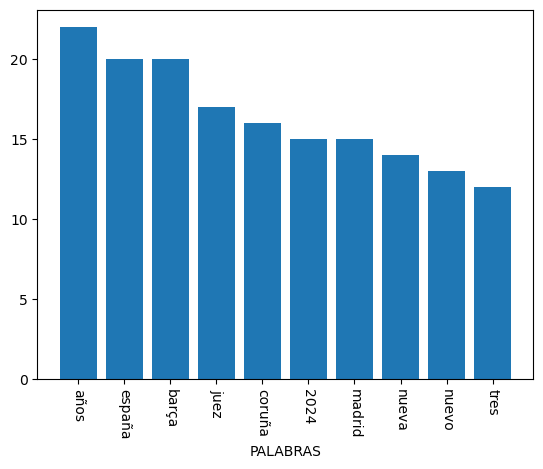

In [142]:
import pprint
import matplotlib.pyplot as plt
from pandas import DataFrame

diccionario_ordenado = sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)
diez_mas_grandes = dict(diccionario_ordenado[:10])
plt.bar(diez_mas_grandes.keys(),diez_mas_grandes.values())
plt.xlabel("PALABRAS")
plt.xticks(rotation=-90)

In [136]:
# Crear una copia del diccionario original
diccionario = deepcopy(datos)
noticias_ordenadas = {}
noticiasOrdenadasPesoRelativo={}
# Obtener la url del diccionario
for url in diccionario.keys():

  # Obtener el subdiccionario asociado a la url
  subdiccionario = diccionario[url]

  # Crear una lista vacía para almacenar las segundas keys y sus pesos relativos
  lista = []

  # Recorrer el subdiccionario y añadir las segundas keys y sus pesos relativos a la lista

  for key, value in subdiccionario.items():
    lista.append((key, value['PesoRelativo']))

  for key, pesoRelativo in lista:
    noticias_ordenadas[key]=pesoRelativo
    noticiasOrdenadasPesoRelativo[key]={url:pesoRelativo}

In [137]:
noticias_ordenadas = dict(sorted(noticias_ordenadas.items(), key=lambda x: x[1],reverse=True))
noticiasOrdenadasPesoRelativo = (sorted(noticias_ordenadas.items(), key=lambda x: x[1],reverse=True))

**Librería para manejo de HTML**

In [ ]:
#!conda install -y -c conda-forge airium
#!conda install -y pymysql

In [139]:
import time
from airium import Airium
from pymysql import Time

a = Airium()


a('<!DOCTYPE html>')
with a.html(lang="pl"):
    with a.head():
        a.meta(charset="utf-8")
        a.title(_t="Página de noticias")
    with a.body():
        for key,value in noticias_ordenadas.items():
            with a.p(style=f"font-size:{value+1}em;"):
                a(key)

html = str(a)  # casting to string extracts the value
# or directly to UTF-8 encoded bytes:
html_bytes = bytes(a)  # casting to bytes is a shortcut to str(a).encode('utf-8')

with open(f"resultado-{time.localtime().tm_year}-{time.localtime().tm_mon}-{time.localtime().tm_mday}.html","w+") as f:
    f.write(html)


In [140]:
veinteTitulares = dict(noticiasOrdenadasPesoRelativo[:20])

In [141]:
veinteTitulares

{'El 1x1 del Barça contra el Athletic': 1.0,
 'Campus Barça Academy 2024': 0.7692307692307693,
 'Un baile que “da la vida” en A Coruña': 0.717948717948718,
 'Xavi: "Este Barça tiene mucho futuro esté yo o no de entrenador"': 0.7076923076923076,
 'Brazos en 3D para una nueva vida': 0.6923076923076923,
 'La IA en España, para cocinar y ver series': 0.6410256410256411,
 'Un ‘regalo’ para el Barça de Grimau': 0.6410256410256411,
 'El Barça de Xavi tiene más futuro que presente': 0.6346153846153846,
 '¿Qué hacer hoy en A Coruña? Agenda del jueves 25 de enero': 0.6307692307692307,
 'El Barça se desangra en defensa': 0.5897435897435898,
 'El Athletic deja KO al Barça en la prórroga de un partidazo': 0.5846153846153845,
 'El juez propone juzgar a Rubiales por el beso no consentido a Jenni Hermoso': 0.5769230769230769,
 'Pletórico Athletic, juvenil Barça': 0.5769230769230769,
 'El juez propone juzgar a Rubiales por el beso a Jennifer Hermoso': 0.5714285714285714,
 'Cómo y cuándo ver la luna lle